## importing dependencies 



In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

### importing the training data of GOOG historical prices

In [4]:
data = pd.read_csv('trainData.csv') 


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


## choosing the close column 


In [6]:
data["Close"]=pd.to_numeric(data.Close,errors='coerce') #turning the Close column to numeric
data = data.dropna() #romeving the NA values
data

Date    Open    High     Low   Close      Volume
0       1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1       1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2       1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3       1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4       1/9/2012  322.04  322.29  309.46  620.76  11,688,800
...          ...     ...     ...     ...     ...         ...
1253  12/23/2016  790.90  792.74  787.28  789.91     623,400
1254  12/27/2016  790.68  797.86  787.66  791.55     789,100
1255  12/28/2016  793.70  794.23  783.20  785.05   1,153,800
1256  12/29/2016  783.33  785.93  778.92  782.79     744,300
1257  12/30/2016  782.75  782.78  770.41  771.82   1,770,000

[1149 rows x 6 columns]

In [8]:
data.iloc[:,4:5]

Close
0     663.59
1     666.45
2     657.21
3     648.24
4     620.76
...      ...
1253  789.91
1254  791.55
1255  785.05
1256  782.79
1257  771.82

[1149 rows x 1 columns]

In [7]:
trainData = data.iloc[:,4:5].values #selecting only the closing prices for training
trainData

array([[663.59],
       [666.45],
       [657.21],
       ...,
       [785.05],
       [782.79],
       [771.82]])

## scaling the values in the range of 0-1 for best preformances 

In [15]:
sc = MinMaxScaler(feature_range=(0,1))
trainData = sc.fit_transform(trainData)
trainData.shape

(1149, 1)

## preparing the data for LSTM
 since its a time series problem we took 60 as timestep for our learning : given *60 closing values* as an input data the *61st value* is our output

In [9]:
X_train = []
y_train = []

for i in range (60,1149): #60 : timestep // 1149 : length of the data
    X_train.append(trainData[i-60:i,0]) 
    y_train.append(trainData[i,0])

X_train,y_train = np.array(X_train),np.array(y_train)

In [10]:
X_train

array([[663.59, 666.45, 657.21, ..., 647.55, 645.25, 653.96],
       [666.45, 657.21, 648.24, ..., 645.25, 653.96, 646.63],
       [657.21, 648.24, 620.76, ..., 653.96, 646.63, 639.48],
       ...,
       [772.56, 776.43, 776.47, ..., 791.26, 789.91, 791.55],
       [776.43, 776.47, 776.86, ..., 789.91, 791.55, 785.05],
       [776.47, 776.86, 775.08, ..., 791.55, 785.05, 782.79]])

In [11]:
y_train

array([646.63, 639.48, 645.15, ..., 785.05, 782.79, 771.82])

ps : LSTM take a 3D tensor (seq_len,timestep,batch_size)

In [13]:
X_train

array([[[663.59],
        [666.45],
        [657.21],
        ...,
        [647.55],
        [645.25],
        [653.96]],

       [[666.45],
        [657.21],
        [648.24],
        ...,
        [645.25],
        [653.96],
        [646.63]],

       [[657.21],
        [648.24],
        [620.76],
        ...,
        [653.96],
        [646.63],
        [639.48]],

       ...,

       [[772.56],
        [776.43],
        [776.47],
        ...,
        [791.26],
        [789.91],
        [791.55]],

       [[776.43],
        [776.47],
        [776.86],
        ...,
        [789.91],
        [791.55],
        [785.05]],

       [[776.47],
        [776.86],
        [775.08],
        ...,
        [791.55],
        [785.05],
        [782.79]]])

In [12]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1)) #adding the batch_size axis
X_train.shape

(1089, 60, 1)

## building the model 

In [8]:
model = Sequential()

model.add(LSTM(units=100, return_sequences = True, input_shape =(X_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units =1))
model.compile(optimizer='adam',loss="mean_squared_error")

In [9]:
hist = model.fit(X_train, y_train, epochs = 20, batch_size = 32, verbose=2)

Epoch 1/20
 - 24s - loss: 0.0423
Epoch 2/20
 - 29s - loss: 0.0108
Epoch 3/20
 - 14s - loss: 0.0093
Epoch 4/20
 - 15s - loss: 0.0084
Epoch 5/20
 - 15s - loss: 0.0086
Epoch 6/20
 - 14s - loss: 0.0063
Epoch 7/20
 - 15s - loss: 0.0068
Epoch 8/20
 - 15s - loss: 0.0066
Epoch 9/20
 - 17s - loss: 0.0063
Epoch 10/20
 - 13s - loss: 0.0054
Epoch 11/20
 - 14s - loss: 0.0072
Epoch 12/20
 - 13s - loss: 0.0065
Epoch 13/20
 - 16s - loss: 0.0071
Epoch 14/20
 - 15s - loss: 0.0050
Epoch 15/20
 - 13s - loss: 0.0049
Epoch 16/20
 - 26s - loss: 0.0055
Epoch 17/20
 - 14s - loss: 0.0047
Epoch 18/20
 - 14s - loss: 0.0048
Epoch 19/20
 - 14s - loss: 0.0044
Epoch 20/20
 - 14s - loss: 0.0045


### ploting the training loss


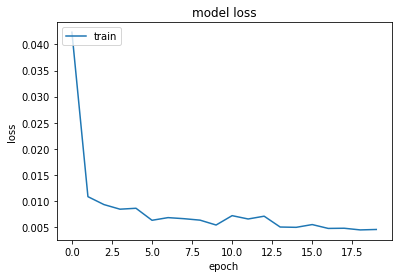

In [10]:
plt.plot(hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

### testing the model on new data


In [32]:
print(len(inputClosing_scaled))
inputClosing_scaled

252


array([[1.72593747],
       [1.74238903],
       [1.67806758],
       [1.65975958],
       [1.6469277 ],
       [1.66272977],
       [1.64845924],
       [1.66170864],
       [1.65718397],
       [1.69261654],
       [1.74173925],
       [1.71698075],
       [1.75909609],
       [1.73547428],
       [1.68690816],
       [1.637739  ],
       [1.61332834],
       [1.57842942],
       [1.5630916 ],
       [1.56265086],
       [1.59216629],
       [1.55842757],
       [1.58745581],
       [1.58095886],
       [1.5427187 ],
       [1.55471499],
       [1.57761733],
       [1.61423333],
       [1.56601533],
       [1.58290791],
       [1.60908211],
       [1.59942916],
       [1.63226289],
       [1.62954792],
       [1.63381766],
       [1.64495541],
       [1.65154527],
       [1.57088811],
       [1.54573505],
       [1.52629008],
       [1.50273795],
       [1.36908291],
       [1.36467409],
       [1.43604965],
       [1.394677  ],
       [1.46203831],
       [1.44906706],
       [1.384

In [33]:
testData = pd.read_csv('GOOG.csv') #importing the test data
testData["Close"]=pd.to_numeric(testData.Close,errors='coerce') #turning the close column to numerical type
testData = testData.dropna() #droping the NA values
testData = testData.iloc[:,4:5] #selecting the closing prices for testing
y_test = testData.iloc[60:,0:].values #selecting the labels 
y_test[0:10]

array([[1055.810059],
       [1093.390015],
       [1082.400024],
       [1066.150024],
       [1038.630005],
       [1036.050049],
       [1043.660034],
       [1064.709961],
       [1061.48999 ],
       [1020.      ]])

In [34]:
#input array for the model
inputClosing = testData.iloc[:,0:].values 
inputClosing_scaled = sc.transform(inputClosing)
inputClosing_scaled[0:10]

array([[1.72593747],
       [1.74238903],
       [1.67806758],
       [1.65975958],
       [1.6469277 ],
       [1.66272977],
       [1.64845924],
       [1.66170864],
       [1.65718397],
       [1.69261654]])

In [35]:
inputClosing_scaled.shape
X_test = []
length = len(testData)
testData

Close
0    1235.010010
1    1242.099976
2    1214.380005
3    1206.489990
4    1200.959961
..           ...
247  1173.989990
248  1204.800049
249  1188.010010
250  1174.709961
251  1197.270020

[252 rows x 1 columns]

In [36]:
length

252

In [37]:
timestep

60

In [38]:
timestep = 60
for i in range(timestep,length): #doing the same preivous preprocessing 
    X_test.append(inputClosing_scaled[i-timestep:i,0])
print(len(X_test))
X_test[0:3]

192


[array([1.72593747, 1.74238903, 1.67806758, 1.65975958, 1.6469277 ,
        1.66272977, 1.64845924, 1.66170864, 1.65718397, 1.69261654,
        1.74173925, 1.71698075, 1.75909609, 1.73547428, 1.68690816,
        1.637739  , 1.61332834, 1.57842942, 1.5630916 , 1.56265086,
        1.59216629, 1.55842757, 1.58745581, 1.58095886, 1.5427187 ,
        1.55471499, 1.57761733, 1.61423333, 1.56601533, 1.58290791,
        1.60908211, 1.59942916, 1.63226289, 1.62954792, 1.63381766,
        1.64495541, 1.65154527, 1.57088811, 1.54573505, 1.52629008,
        1.50273795, 1.36908291, 1.36467409, 1.43604965, 1.394677  ,
        1.46203831, 1.44906706, 1.38474562, 1.4044458 , 1.41535185,
        1.42122225, 1.29828745, 1.40238061, 1.346459  , 1.2272137 ,
        1.26464164, 1.35875724, 1.34304808, 1.31471607, 1.27364481]),
 array([1.74238903, 1.67806758, 1.65975958, 1.6469277 , 1.66272977,
        1.64845924, 1.66170864, 1.65718397, 1.69261654, 1.74173925,
        1.71698075, 1.75909609, 1.73547428, 1.

In [25]:
X_test = np.array(X_test)
X_test

array([[1.72593747, 1.74238903, 1.67806758, ..., 1.34304808, 1.31471607,
        1.27364481],
       [1.74238903, 1.67806758, 1.65975958, ..., 1.31471607, 1.27364481,
        1.31012173],
       [1.67806758, 1.65975958, 1.6469277 , ..., 1.27364481, 1.31012173,
        1.39732229],
       ...,
       [1.56165296, 1.59592533, 1.5572212 , ..., 1.57497204, 1.58434655,
        1.65583824],
       [1.59592533, 1.5572212 , 1.50280763, ..., 1.58434655, 1.65583824,
        1.61687862],
       [1.5572212 , 1.50280763, 1.52782162, ..., 1.65583824, 1.61687862,
        1.58601717]])

In [26]:
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
X_test

array([[[1.72593747],
        [1.74238903],
        [1.67806758],
        ...,
        [1.34304808],
        [1.31471607],
        [1.27364481]],

       [[1.74238903],
        [1.67806758],
        [1.65975958],
        ...,
        [1.31471607],
        [1.27364481],
        [1.31012173]],

       [[1.67806758],
        [1.65975958],
        [1.6469277 ],
        ...,
        [1.27364481],
        [1.31012173],
        [1.39732229]],

       ...,

       [[1.56165296],
        [1.59592533],
        [1.5572212 ],
        ...,
        [1.57497204],
        [1.58434655],
        [1.65583824]],

       [[1.59592533],
        [1.5572212 ],
        [1.50280763],
        ...,
        [1.58434655],
        [1.65583824],
        [1.61687862]],

       [[1.5572212 ],
        [1.50280763],
        [1.52782162],
        ...,
        [1.65583824],
        [1.61687862],
        [1.58601717]]])

In [39]:
y_pred = model.predict(X_test) #predicting the new values

NameError: name 'model' is not defined

In [13]:
predicted_price = sc.inverse_transform(y_pred) #inversing the scaling transformation for ploting 

### ploting the results

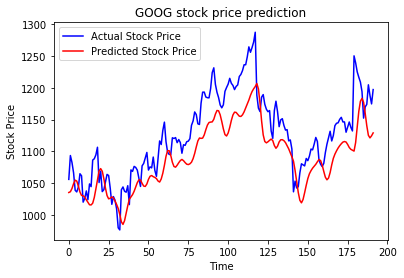

In [14]:
plt.plot(y_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price, color = 'red', label = 'Predicted Stock Price')
plt.title('GOOG stock price prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()